# Banzhaf Semi-values for data valuation

This notebook showcases [Data Banzhaf: A Robust Data Valuation Framework for Machine Learning](https://proceedings.mlr.press/v206/wang23e.html) by Wang, and Jia.

Computing Banzhaf semi-values using pyDVL follows basically the same procedure as all other semi-value-based methods like Shapley values. However, Data-Banzhaf tends to be more robust to stochasticity in the training process than other semi-values. A property that we study here.

Additionally, we compare two sampling techniques: the standard permutation-based Monte Carlo sampling, and the so-called MSR (Maximum Sample Reuse) principle.

In order to highlight the strengths of Data-Banzhaf, we require a stochastic model. For this reason, we use a CNN to classify handwritten MNIST digits from the [scikit-learn toy datasets](https://scikit-learn.org/stable/datasets/toy_dataset.html#optical-recognition-of-handwritten-digits-dataset).

To showcase the use of pytorch with valuation methods, the network is a [skorch](https://github.com/skorch-dev/skorch) model.

## Setup

<div class="alert alert-info">

If you are reading this in the documentation, some boilerplate (including most plotting code) has been omitted for convenience.

</div>

In [1]:
from __future__ import annotations

%matplotlib inline

import os
import random
import warnings
from collections import OrderedDict, defaultdict
from typing import Type

import matplotlib.pyplot as plt
import numpy as np
import torch
from support.common import filecache
from support.datasets import load_digits_dataset

from pydvl.reporting.plots import plot_result_errors

warnings.filterwarnings("ignore")

plt.ioff()  # Prevent jupyter from automatically plotting
plt.rcParams["figure.figsize"] = (20, 6)
plt.rcParams["font.size"] = 12
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["axes.facecolor"] = (1, 1, 1, 0)
plt.rcParams["figure.facecolor"] = (1, 1, 1, 0)

is_CI = os.environ.get("CI")
device = "cuda" if torch.cuda.is_available() else "cpu"
random_state = 42

n_jobs = 16
n_epochs = 24
batch_size = 64
random.seed(random_state)
torch.manual_seed(random_state);

## The dataset

The data consists of ~1800 grayscale images of 8x8 pixels with 16 shades of gray. These images contain handwritten digits from 0 to 9. The helper function `load_digits_dataset()` downloads and prepares it for usage returning two [Datasets][pydvl.valuation.dataset.Dataset].

In [2]:
train, test = load_digits_dataset(
    train_size=0.7, random_state=random_state, device=device
)

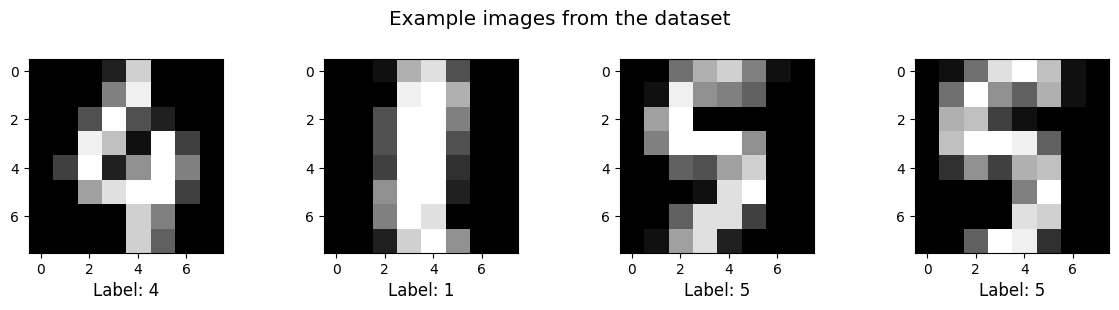

In [3]:
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for i in range(4):
    ax = axes[i]
    ax.imshow(train.data().x[i].reshape((8, 8)).cpu(), cmap="gray")
    ax.set_xlabel(f"Label: {train.data().y[i]}")
plt.suptitle("Example images from the dataset")
plt.tight_layout()
plt.show();

## Creating the utility and computing Banzhaf semi-values

Now we can calculate the contribution of each training sample to the model performance. We use a simple CNN written in torch and wrap it into a [skorch.classifier.NeuralNetClassifier][]. Note that any model that implements the protocol [SupervisedModel][pydvl.utils.types.SupervisedModel], which is just the standard sklearn interface of `fit()`,`predict()` and `score()` can be used to construct the utility, so it is possible to construct your own wrapper. Nevertheless, skorch conveniently implements the full sklearn interface, allowing e.g. the use of torch models in pipelines.

It's important to note the use `torch_load_kwargs={"weights_only": False}` in the model definition. This is necessary to ensure that pickling works correctly, which is required for parallel operation. It should also be possible to use `torch.serialization.add_safe_globals()`, following the suggestion in pytorch's documentation.

In [4]:
# Reduce computation time in CI
if is_CI:
    train = train[:10]
    test = test[:10]
    n_jobs = 1
    n_epochs = 1
    batch_size = 1
    filecache = lambda x: lambda y: y  # passthrough

In [5]:
from skorch import NeuralNetClassifier
from support.banzhaf import SimpleCNN

model = NeuralNetClassifier(
    SimpleCNN,
    criterion=torch.nn.CrossEntropyLoss,
    lr=0.01,
    max_epochs=n_epochs,
    batch_size=batch_size,
    train_split=None,
    optimizer=torch.optim.Adam,
    device=device,
    verbose=False,
    torch_load_kwargs={"weights_only": False},
)
model.fit(*train.data());

In [6]:
print(f"Training accuracy: {model.score(*train.data().cpu()):.3f}")
print(f"Test accuracy: {model.score(*test.data().cpu()):.3f}")

Training accuracy: 0.995
Test accuracy: 0.978


As with all other model-based valuation methods, for Data Banzhaf we need a scoring function to measure performance of the model over the test set. We will use accuracy, but it can be anything, like e.g. $R^2$, using strings from the [standard sklearn scoring methods](https://scikit-learn.org/stable/modules/model_evaluation.html), passed to [SkorchSupervisedScorer][pydvl.valuation.scorers.skorch.SkorchSupervisedScorer].

We group our torch model and the scoring function into an instance of [ModelUtility][pydvl.valuation.utility.ModelUtility].

In [7]:
from pydvl.valuation.samplers import PermutationSampler, RelativeTruncation
from pydvl.valuation.scorers import SkorchSupervisedScorer
from pydvl.valuation.stopping import MinUpdates
from pydvl.valuation.utility import ModelUtility

accuracy_over_test_set = SkorchSupervisedScorer(
    model, test_data=test, default=0.0, range=(0, 1)
)

utility = ModelUtility(model=model, scorer=accuracy_over_test_set)

In order to compute the Banzhaf semi-values, we use [BanzhafValuation][pydvl.valuation.methods.banzhaf.BanzhafValuation], which also requires choosing a sampler and a stopping criterion.

We use the standard [PermutationSampler][pydvl.valuation.samplers.permutation.PermutationSampler], and choose to stop computation using the [MinUpdates][pydvl.valuation.stopping.MinUpdates] stopping criterion, which terminates after a fixed number of value updates. This is a simple stopping criterion, but it is not very efficient. We will later compare it to [RankCorrelation][pydvl.valuation.stopping.RankCorrelation], which terminates after the change in Spearman correlation between two successive iterations is below a certain threshold.

We also define a relative [TruncationPolicy][pydvl.valuation.samplers.truncation.TruncationPolicy], which is a policy used to early-stop computation of marginal values in permutations, once the utility is close to the total utility. This is a heuristic to speed up computation introduced in the Data-Shapley paper called Truncated Monte Carlo Shapley. Note how we tell it to wait until at least 30% of every permutation has been processed in order to start evaluation. This is to ensure that noise doesn't stop the computation too early.

In [8]:
truncation = RelativeTruncation(rtol=0.05, burn_in_fraction=0.3)
sampler = PermutationSampler(truncation=truncation)
stopping = MinUpdates(100)

In [9]:
if is_CI:
    from pydvl.valuation.stopping import MaxChecks

    stopping = MaxChecks(1)  # Stop after 1 utility evaluation

We now instantiate and fit the valuation. Note how parallelization is just a matter of using joblib's context manager `parallel_config` in order to set the number of jobs.

In [10]:
from joblib import parallel_config

from pydvl.valuation.methods import BanzhafValuation

valuation = BanzhafValuation(utility, sampler=sampler, is_done=stopping, progress=True)

# filecache is a very simple wrapper not intended for production code
cached_fit = filecache("digits_banzhaf_result.pkl")(lambda d: valuation.fit(d).result)
with parallel_config(n_jobs=n_jobs):
    result = cached_fit(train)

Found cached file: digits_banzhaf_result.pkl.


The results object is of type [ValuationResult][pydvl.valuation.result.ValuationResult], and contains values, variances and number of updates of the Monte Carlo estimates. It can be indexed, sliced and copied in natural ways, as we illustrate below.

Let us plot the results. In the next cell we will take the 10 images with the lowest score and plot their values with 95% Normal confidence intervals. Keep in mind that Permutation Monte Carlo Banzhaf is typically very noisy, and it can take many steps to arrive at a clean estimate.

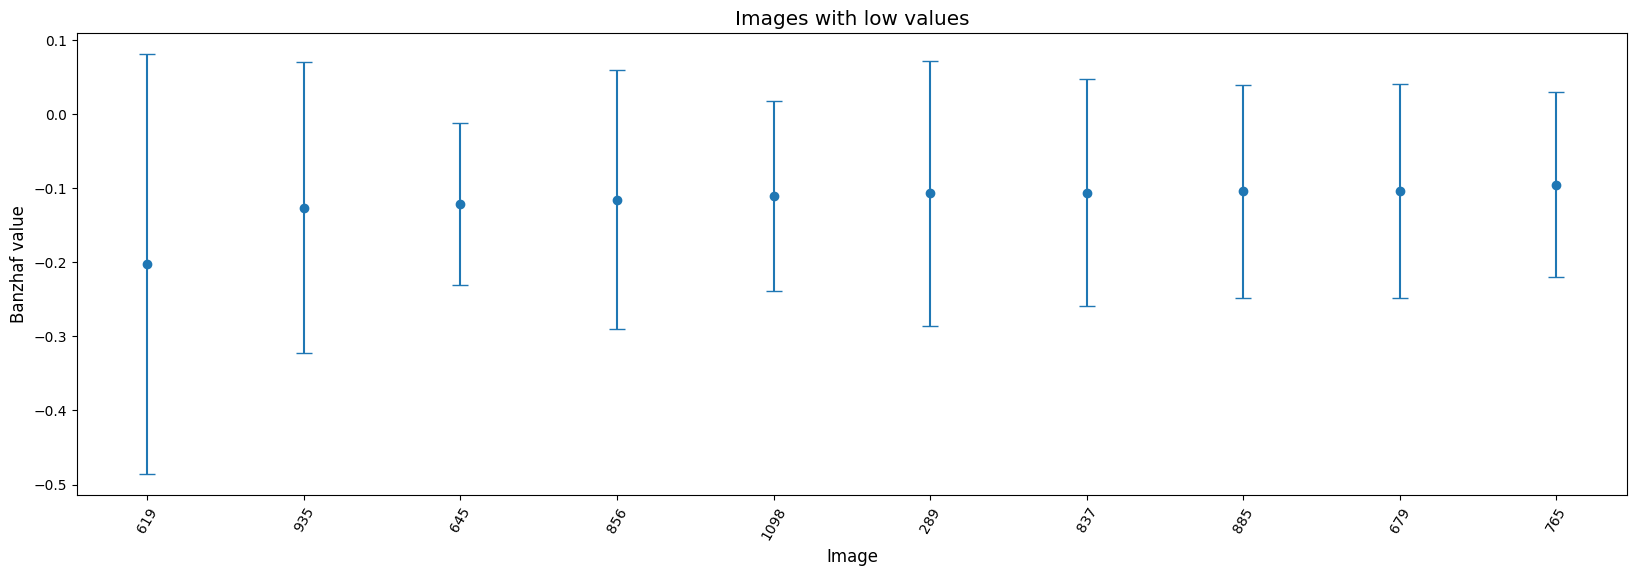

In [11]:
bottom = result.sort()[:10]
plot_result_errors(
    bottom,
    level=0.05,
    title="Images with low values",
    xlabel="Image",
    ylabel="Banzhaf value",
)
plt.show();

## Evaluation on anomalous data

An interesting use-case for data valuation is finding anomalous data. Maybe some of the data is really noisy or has been mislabeled. To simulate this for our dataset, we will change some of the labels and add noise to some images. Intuitively, these anomalous data points should then have a lower value.

To evaluate this, let us first check the average value of the 10 data points with the highest value, as these will be the ones that we modify:

In [12]:
top = result.sort()[-10:]
print(f"Average value of top 10 data points: {top.values.mean():.4f}")

Average value of top 10 data points: 0.1105


For the first 5 images, we will falsify their label, for images 6-10, we will add some noise.

In [13]:
x_train_anomalous = train.data().x.clone()
y_train_anomalous = train.data().y.clone()
anomalous_indices = top.indices

# Change the label of the first 5 images
y_train_anomalous[anomalous_indices[:5]] = torch.remainder(
    y_train_anomalous[anomalous_indices[:5]] + 1, 10
)
# Add noise to images 6-10
current_images = x_train_anomalous[anomalous_indices[5:10]]
noisy_images = current_images + 0.5 * torch.randn_like(current_images)
noisy_images[noisy_images < 0] = 0.0
noisy_images[noisy_images > 1] = 1.0
x_train_anomalous[anomalous_indices[5:10]] = noisy_images

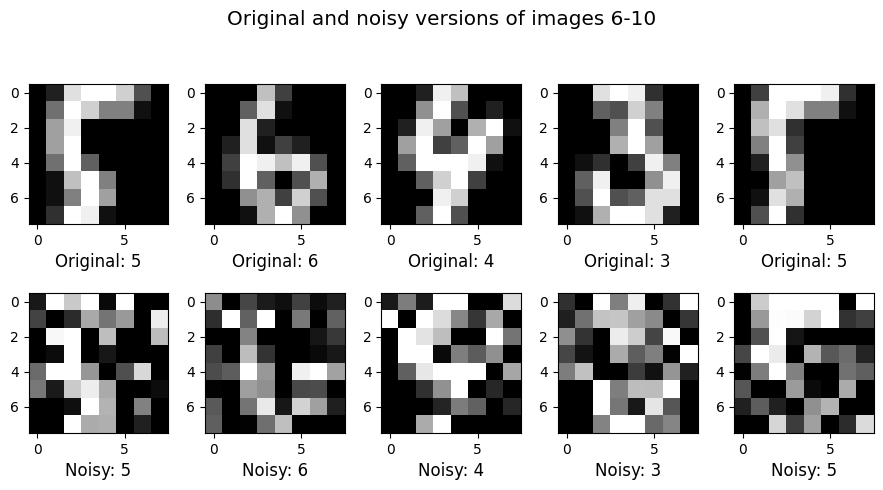

In [14]:
fig, axes = plt.subplots(2, 5, figsize=(9, 5))
for i in range(5):
    axes[0, i].imshow(current_images[i].reshape((8, 8)).cpu(), cmap="gray")
    axes[1, i].imshow(noisy_images[i].reshape((8, 8)).cpu(), cmap="gray")
    axes[0, i].set_xlabel(f"Original: {train.data().y[anomalous_indices[5 + i]]}")
    axes[1, i].set_xlabel(f"Noisy: {y_train_anomalous[anomalous_indices[5 + i]]}")
plt.suptitle("Original and noisy versions of images 6-10")
plt.tight_layout()
plt.show();

In [15]:
from pydvl.valuation.dataset import Dataset

anomalous_dataset = Dataset(x=x_train_anomalous, y=y_train_anomalous)

# Note that we reuse the same stopping criterion. fit() resets it, but
# to be sure we can always call stopping.reset()
anomalous_valuation = BanzhafValuation(
    utility, sampler=sampler, is_done=stopping.reset(), progress=True
)

cached_fit = filecache("digits_banzhaf_anomalous_result.pkl")(
    lambda d: valuation.fit(d).result
)
with parallel_config(n_jobs=n_jobs):
    new_result = cached_fit(anomalous_dataset)

Found cached file: digits_banzhaf_anomalous_result.pkl.


Let us now look at how the value has changed for the images that we manipulated:

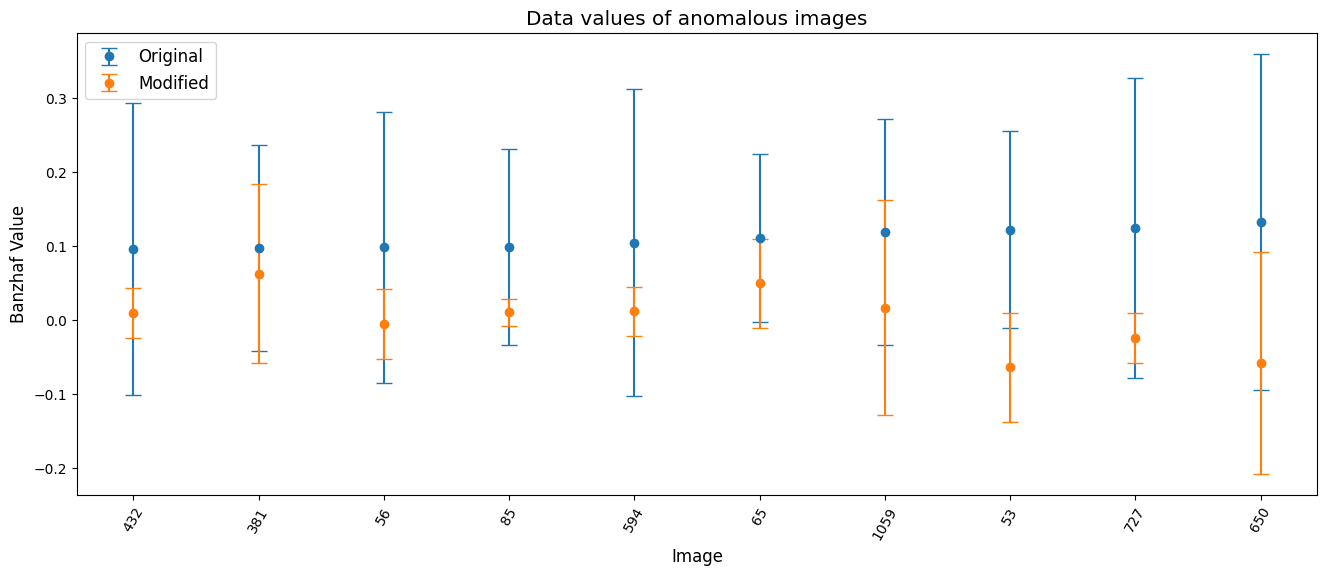

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(16, 6))
plot_result_errors(result[anomalous_indices], ax=ax, legend_label="Original")
plot_result_errors(
    new_result[anomalous_indices],
    ax=ax,
    xlabel="Image",
    ylabel="Banzhaf Value",
    legend_label="Modified",
)
ax.set_title("Data values of anomalous images")
plt.legend()
plt.xticks(rotation=60)
plt.show();

As can be seen in this figure, the valuation of the data points has decreased significantly by adding noise or falsifying their labels. This shows the potential of using Banzhaf values or other data valuation methods to detect mislabeled data points or noisy input data.

In [17]:
print(
    f"Average value of intervened indices before modification: "
    f"{result[anomalous_indices].values.mean():.4f}"
)
print(
    f"Average value of intervened indices after modification: "
    f"{new_result[anomalous_indices].values.mean():.4f}"
)
print("For reference:")
print(f"Average value of all original indices: {result.values.mean():.4f}")
print(
    "Average value of all indices in the modified dataset:"
    f"{new_result.values.mean():.4f}"
)

Average value of intervened indices before modification: 0.1105
Average value of intervened indices after modification: 0.0009
For reference:
Average value of all original indices: 0.0005
Average value of all indices in the modified dataset:0.0004


## Maximum Sample Reuse Banzhaf

Despite the previous results already being useful, we had to retrain the model a number of times and yet the variance of the value estimates was high. This has consequences for the stability of the top-k ranking of points, which decreases the applicability of the method. We will now use a different sampling method called Maximum Sample Reuse (MSR) which reuses every sample for updating the Banzhaf values. The method was introduced by the authors of Data-Banzhaf and is much more sample-efficient, as we will show.

In order to compute the values with MSR we use [MSRBanzhafValuation][pydvl.valuation.methods.banzhaf.MSRBanzhafValuation].

Because values converge much faster, we can use a better stopping criterion. Instead of fixing the number of value updates with [MinUpdates][pydvl.valuation.stopping.MinUpdates], we use [RankCorrelation][pydvl.valuation.stopping.RankCorrelation] to stop when the change in Spearman correlation between the ranking of two successive iterations is below a threshold.

In [18]:
from pydvl.valuation.stopping import RankCorrelation

stopping = RankCorrelation(rtol=1e-2, burn_in=32)

In [19]:
if is_CI:
    stopping = MaxChecks(1)

Despite the much stricter stopping criterion, fitting the Banzhaf values with the MSR sampler is much faster:

In [20]:
from pydvl.valuation.methods import MSRBanzhafValuation

valuation = MSRBanzhafValuation(
    utility,
    is_done=stopping,
    batch_size=32,
    seed=random_state,
    progress=True,
)

cached_fit = filecache("digits_msr_banzhaf_result.pkl")(
    lambda d: valuation.fit(d).result
)
with parallel_config(n_jobs=n_jobs):
    msr_result = cached_fit(train)

Found cached file: digits_msr_banzhaf_result.pkl.


Inspection of the values reveals (generally) much lower variances. Notice the number of updates to each value as well.

In [21]:
msr_result.sort().to_dataframe(column="msr")

,msr,msr_variances,msr_counts
763,-0.035415,0.009960,93
1,-0.035242,0.009103,92
1001,-0.032764,0.009999,93
419,-0.029643,0.010003,93
991,-0.029437,0.010079,94
...,...,...,...
246,0.026680,0.009193,85
1110,0.026708,0.010152,95
233,0.028418,0.008097,80
87,0.029128,0.010114,95


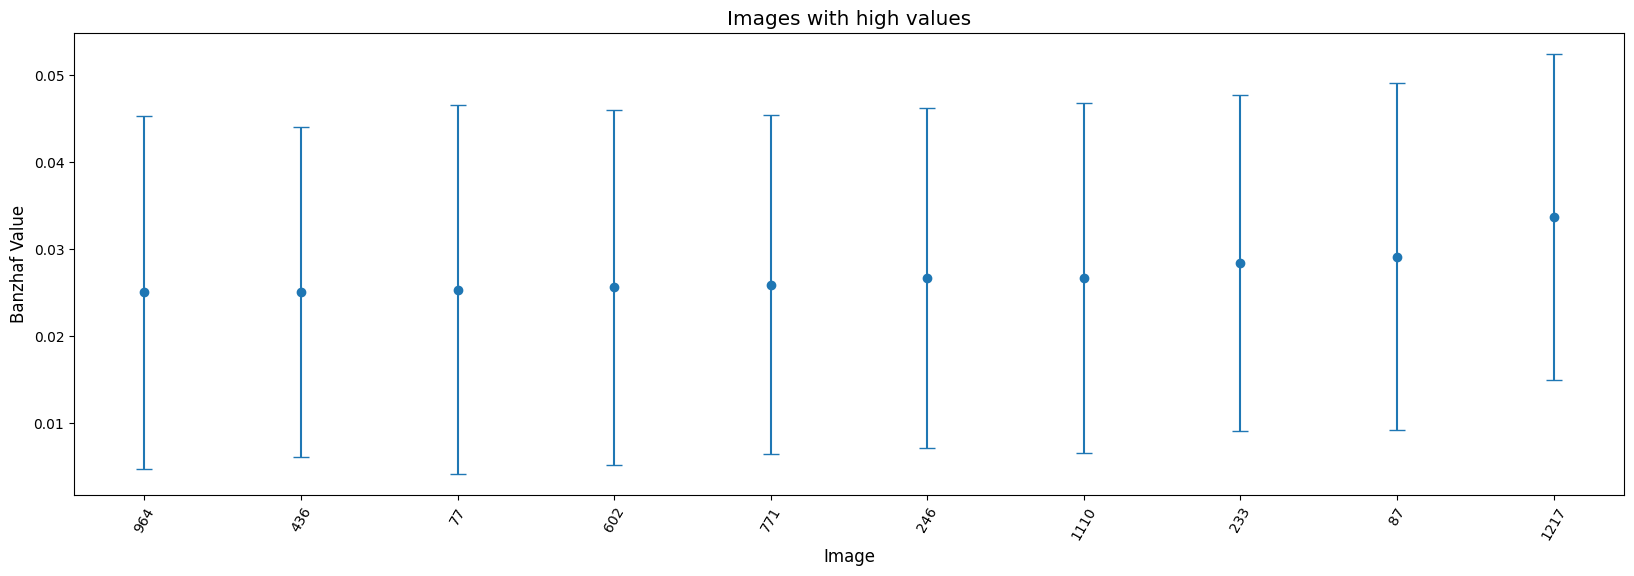

In [22]:
top = msr_result.sort()[-10:]
_ = plot_result_errors(
    top,
    title="Images with high values",
    xlabel="Image",
    ylabel="Banzhaf Value",
)
plt.show();

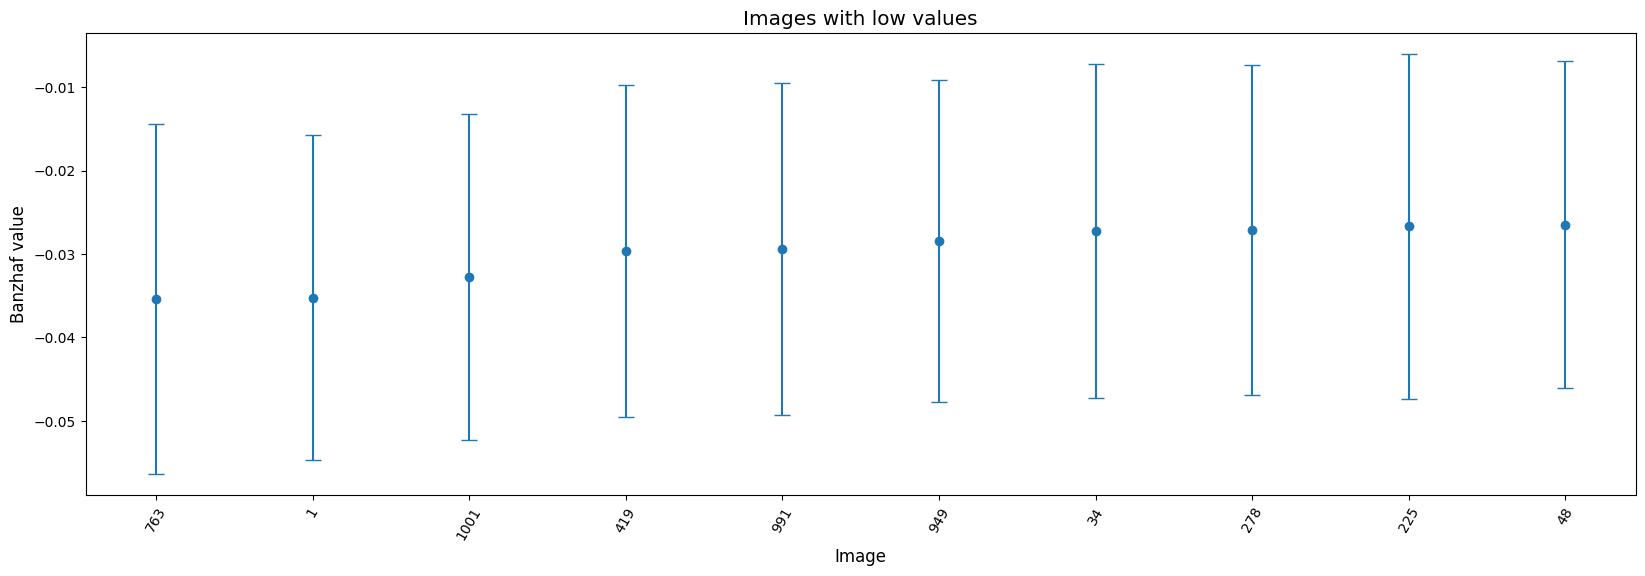

In [23]:
bottom = msr_result.sort()[:10]
_ = plot_result_errors(
    bottom,
    title="Images with low values",
    xlabel="Image",
    ylabel="Banzhaf value",
)
plt.show();

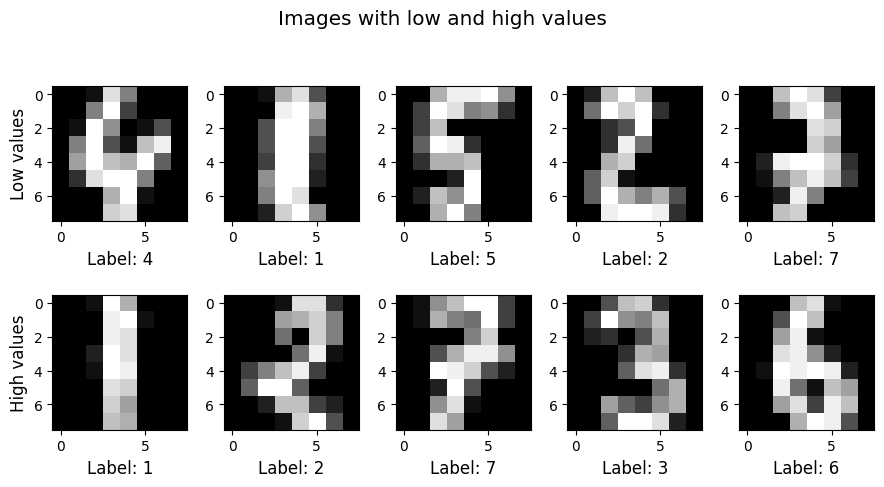

In [25]:
low_images = train[bottom.indices].data().x
low_labels = train[bottom.indices].data().y
high_images = train[top.indices].data().x
high_labels = train[top.indices].data().y

_, axes = plt.subplots(2, 5, figsize=(9, 5))
for i in range(5):
    axes[0, i].imshow(low_images[i].reshape((8, 8)).cpu(), cmap="gray")
    axes[1, i].imshow(high_images[i].reshape((8, 8)).cpu(), cmap="gray")
    axes[0, i].set_xlabel(f"Label: {low_labels[i]}")
    axes[1, i].set_xlabel(f"Label: {high_labels[i]}")

axes[0, 0].set_ylabel("Low values")
axes[1, 0].set_ylabel("High values")
plt.suptitle("Images with low and high values")
plt.tight_layout()
plt.show();

### Convergence speed of Banzhaf and MSR Banzhaf Values

Conventional margin-based samplers produce require evaluating the utility twice to do one update of the value, and permutation samplers do instead $n+1$ evaluations for $n$ updates. Maximum Sample Reuse (MSR) updates instead all indices in every sample that the utility evaluates. We compare the convergence rates of these methods.

In order to do so, we will compute the semi-values using different samplers and use a high number of iterations to make sure that the values have converged.

In [ ]:
max_checks = 1000
moving_avg = 200

In [ ]:
if is_CI:
    from sklearn.linear_model import SGDClassifier

    max_checks = 1
    moving_avg = 1
    utility = ModelUtility(
        model=SGDClassifier(max_iter=2), scorer=accuracy_over_test_set
    )

In [ ]:
from pydvl.utils import maybe_add_argument
from pydvl.valuation import IndexSampler, SemivalueValuation, ValuationResult
from pydvl.valuation.stopping import History, MaxChecks


def compute_semivalues_and_history(
    method_t: Type[SemivalueValuation],
    sampler_t: Type[IndexSampler],
    sampler_args: dict,
    max_checks: int,
    progress: bool = True,
) -> tuple[History, ValuationResult]:
    history = History(n_steps=max_checks)
    wrapper = maybe_add_argument(sampler_t, "seed")
    utility.show_warnings = True
    valuation = method_t(
        utility,
        sampler=wrapper(**sampler_args, seed=random_state),
        is_done=MaxChecks(max_checks + 2) | history,
        progress=progress,
    )

    @filecache(
        f"digits_banzhaf_comparison_{method_t.__name__}_{sampler_t.__name__}_result.pkl"
    )
    def cached_fit(data) -> tuple[History, ValuationResult]:
        valuation.fit(data)
        return history, valuation.result

    with parallel_config(n_jobs=n_jobs):
        return cached_fit(train)

In [ ]:
from pydvl.valuation.samplers import (
    AntitheticSampler,
    HarmonicSampleSize,
    MSRSampler,
    RandomIndexIteration,
    RandomSizeIteration,
    StratifiedSampler,
    UniformSampler,
)

experiments = OrderedDict(
    [
        (
            PermutationSampler,
            {
                "name": "Permutation",
                "kwargs": {
                    "truncation": RelativeTruncation(rtol=0.05, burn_in_fraction=0.3),
                },
            },
        ),
        (MSRSampler, {"name": "MSR", "kwargs": {"batch_size": 16}}),
        (UniformSampler, {"name": "Uniform", "kwargs": {}}),
        (AntitheticSampler, {"name": "Antithetic", "kwargs": {}}),
        (
            StratifiedSampler,
            {
                "name": "Stratified",
                "kwargs": {
                    "sample_sizes": HarmonicSampleSize(1),
                    "sample_sizes_iteration": RandomSizeIteration,
                    "index_iteration": RandomIndexIteration,
                },
            },
        ),
    ]
)

results = {}
history = {}

for sampler_t, params in experiments.items():
    history[sampler_t], results[sampler_t] = compute_semivalues_and_history(
        BanzhafValuation, sampler_t, params.get("kwargs", {}), max_checks
    )

In [ ]:
# Compare convergence speed of all methods
all_values = {
    sampler_t: history[sampler_t].memory.data for sampler_t in experiments.keys()
}
distances = {sampler_t: [] for sampler_t in experiments.keys()}
moving_avgs = {}

for sampler_t, params in experiments.items():
    for iteration in range(max_checks):
        abs_dist = np.abs(
            all_values[sampler_t][:, iteration]
            - all_values[sampler_t][:, iteration + 1]
        )
        if abs_dist.max() == 0.0:
            distances[sampler_t].append(0.0)
        else:
            distances[sampler_t].append(np.mean(abs_dist[abs_dist > 0]))
    moving_avgs[sampler_t] = np.convolve(
        distances[sampler_t], np.ones(moving_avg) / moving_avg, mode="same"
    )

fig, ax = plt.subplots(1, 1)
for sampler_t, params in experiments.items():
    ax.plot(list(range(max_checks)), moving_avgs[sampler_t], label=params["name"])
ax.set_xlabel("Iteration")
ax.set_ylabel("Mean semi-value change between iterations")
ax.set_title("Convergence speed of different samplers")
plt.yscale("log")
plt.ylim(1e-5, 1)
plt.legend()
plt.show();

The plot above visualizes the convergence speed of different samplers used for Banzhaf semi-value calculation. It shows the average magnitude of how much the semi-values are updated in every step of the algorithm.

As you can see, **MSR Banzhaf** stabilizes much faster. After 1000 iterations (subsets sampled and evaluated with the utility), Permutation Monte Carlo Banzhaf has evaluated the marginal function about 5 times per data point (we are using 200 data points). For MSR, the semi-value of each data point was updated 1000 times. Due to this, the values converge much faster wrt. the number of utility evaluations, which is the key advantage of MSR sampling.

MSR sampling does come at a cost, however, which is that the updates to the semi-values are more noisy than in other methods.  We will analyze the impact of this tradeoff in the next sections. First, let us look at how similar all the computed semi-values are. They are all Banzhaf values, so in a perfect world, all samplers should result in the exact same semi-values. However, due to randomness in the utility (recall that we use a neural network) and randomness in the samplers, the resulting values are likely never exactly the same. Another quality measure is that a good sampler would lead to very consistent values, a bad one to less consistent values. Let us first examine how similar the results are, then we'll look at consistency.

## Similarity of the semi-values computed using different samplers

In [ ]:
top_consistency = np.zeros((len(experiments), len(experiments)))
low_consistency = np.zeros((len(experiments), len(experiments)))
twenty_percent = train.data().x.shape[0] // 5

for i, (sampler1_t, sampler1_values) in enumerate(results.items()):
    for j, (sampler2_t, sampler2_values) in enumerate(results.items()):
        sampler1_values.sort(key="value", inplace=True)
        sampler2_values.sort(key="value", inplace=True)
        top_20_1 = set(sampler1_values.indices[-twenty_percent:].tolist())
        lower_20_1 = set(sampler1_values.indices[:twenty_percent].tolist())
        top_20_2 = set(sampler2_values.indices[-twenty_percent:].tolist())
        lower_20_2 = set(sampler2_values.indices[:twenty_percent].tolist())
        top_consistency[i, j] = len(top_20_1.intersection(top_20_2))
        low_consistency[i, j] = len(lower_20_1.intersection(lower_20_2))

In [ ]:
names = [v["name"] for _, v in experiments.items()]
fix, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].matshow(top_consistency, vmin=0, vmax=twenty_percent)
mat2 = axes[1].matshow(low_consistency, vmin=0, vmax=twenty_percent)
axes[0].set_xticks(np.arange(len(experiments)), names, rotation=90)
axes[1].set_xticks(np.arange(len(experiments)), names, rotation=90)
for (i, j), z in np.ndenumerate(top_consistency):
    axes[0].text(j, i, f"{int(z)}", ha="center", va="center", c="white")
for (i, j), z in np.ndenumerate(low_consistency):
    axes[1].text(j, i, f"{int(z)}", ha="center", va="center", c="white")

axes[0].set_yticks(np.arange(len(experiments)), names)
axes[1].set_yticks(np.arange(len(experiments)), names)
axes[0].set_title("Top 20% of points")
axes[1].set_title("Low 20% of points")
fig.colorbar(mat2)
plt.suptitle("Overlapping high and low value points between samplers")
plt.tight_layout()
plt.show()

This plot shows that the samplers lead to quite different Banzhaf semi-values, however, all of them have some points in common. The MSR Sampler does not seem to be significantly worse than any others.

In an ideal setting without randomness, the overlap of points would be higher, however, the stochastic nature of the CNN model that we use together with the fact that we use only 200 data points for training, might overshadow these results. As a matter of fact we have the rather discouraging following result:

In [ ]:
all_in_common = set(results[PermutationSampler].indices.tolist())
for sampler_t, sampler_values in results.items():
    sampler_values.sort(key="value", inplace=True)
    top_20 = set(sampler_values.indices[-twenty_percent:].tolist())
    all_in_common = all_in_common.intersection(top_20)
print(
    f"Total number of top 20 points that all samplers have in common: {len(all_in_common)}"
)

### Consistency of the semi-values

Finally, we want to analyze how consistent the semi-values are when computed using the different samplers. In order to do this, we calculate them multiple times and check how many of the data points in the top and lowest 20% of the valuation overlap.

In [ ]:
max_checks = 1000
n_runs = 5

In [ ]:
if is_CI:
    n_runs = 1
    max_checks = 1

In [ ]:
from tqdm.notebook import tqdm

all_results = defaultdict(lambda: defaultdict(list))
snapshot_times = np.linspace(0, max_checks, 20, dtype=int)

with tqdm(total=n_runs * len(experiments), position=0) as pbar:
    for sampler_t, params in experiments.items():
        for _ in range(n_runs):
            history, vals = compute_semivalues_and_history(
                BanzhafValuation,
                sampler_t,
                params.get("kwargs", {}),
                max_checks,
                progress=False,
            )
            for step in snapshot_times:
                raw_values = history[-(max_checks - step)]
                # We will want to access the indices later, so we use a fake object
                fake_result = ValuationResult(indices=vals.indices, values=raw_values)
                all_results[sampler_t][step].append(fake_result)
            pbar.n += 1
            pbar.refresh()

In [ ]:
# Extract results from experiments
twenty_percent = train.data().x.shape[0] // 5
plot_results_top = defaultdict(list)
plot_results_low = defaultdict(list)
for sampler_t, params in experiments.items():
    for step in snapshot_times:
        values_for_all_runs = all_results[sampler_t][step]
        top_20 = None
        lower_20 = None
        for vals in values_for_all_runs:
            vals.sort(key="value", inplace=True)
            if top_20 is None:
                top_20 = set(vals.indices[-twenty_percent:].tolist())
                lower_20 = set(vals.indices[:twenty_percent].tolist())
            else:
                top_20 = top_20.intersection(
                    set(vals.indices[-twenty_percent:].tolist())
                )
                lower_20 = lower_20.intersection(
                    set(vals.indices[:twenty_percent].tolist())
                )
        plot_results_top[sampler_t].append(len(top_20) / 20)
        plot_results_low[sampler_t].append(len(lower_20) / 20)

In [ ]:
fig, axes = plt.subplots(1, 2)
for sampler_t, params in experiments.items():
    axes[0].plot(snapshot_times, plot_results_top[sampler_t], label=params["name"])
    axes[1].plot(snapshot_times, plot_results_low[sampler_t], label=params["name"])
axes[0].legend()
axes[1].legend()
axes[0].set_xlabel("Number of iterations")
axes[1].set_xlabel("Number of iterations")
axes[0].set_ylabel(f"Fraction of common points \nin top 20% across {n_runs} runs")
axes[1].set_ylabel(f"Fraction of common points \nin lower 20% across {n_runs} runs")
fig.suptitle(f"Consistency of samplers (max. value: {twenty_percent})")
fig.tight_layout()
plt.show();

## Conclusion

MSR sampling updates the semi-value estimates for every index in the sample, much more frequently than any other sampler available, which leads to much **faster convergence**. Additionally, the sampler is more consistent with its value estimates than the other samplers, which might be caused by the higher number of value updates.

There is alas no general recommendation. It is best to try different samplers when computing semi-values and test which one is best suited for your use case. Nevertheless, the MSR sampler seems like a more efficient sampler which may bring fast results and is well-suited for stochastic models.